In [1]:
%cd ..

/home/jetson/embedded-ml-lab-students-ss24/emb-ml-challenge


In [2]:
import time
import cv2
import torch
import tqdm
from utils.tinyyolov2 import TinyYoloV2Fused, TinyYoloV2, TinyYoloV2Pruned
from utils.yolo import nms, filter_boxes
import numpy as np
from utils.dataloader import VOCDataLoaderPerson
import torchvision

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# import torch_directml
# device = torch_directml.device()
# print(device)

In [5]:
def apply_bboxes(image, output):
    img_shape = 320
    
    bboxes = torch.stack(output, dim=0)
    
    for i in range(bboxes.shape[1]):

        # only show person
        # if int(bboxes[0,i,5]) != 14:
        #    continue
        
        if bboxes[0,i,-1] >= 0:
            
            cx = int(bboxes[0,i,0]*img_shape - bboxes[0,i,2]*img_shape/2)
            cy = int(bboxes[0,i,1]*img_shape - bboxes[0,i,3]*img_shape/2)

            w = int(bboxes[0,i,2]*img_shape)
            h = int(bboxes[0,i,3]*img_shape)
            
            cv2.rectangle(image, (cx, cy), (cx + w, cy + h), color=(255,0,0), thickness=2)

            # annotation = num_to_class(int(bboxes[0,i,5])) + " "+  f"{float(bboxes[0,i,4]):.2f}"
            annotation = f"{float(bboxes[0,i,4]):.2f}"
            
            cv2.putText(image, annotation, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 0), 2, cv2.LINE_AA)
            
    return image

def apply_fps(image):
    fps = 0
    cv2.putText(image, f"{fps}fps", (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 0), 2, cv2.LINE_AA)
    return image

In [6]:
def xyxy2xywh(x):
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = (x[..., 0] + x[..., 2]) / 2  # x center
    y[..., 1] = (x[..., 1] + x[..., 3]) / 2  # y center
    y[..., 2] = x[..., 2] - x[..., 0]  # width
    y[..., 3] = x[..., 3] - x[..., 1]  # height
    return y

def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None):
    """Performs Non-Maximum Suppression (NMS) on inference results
    Returns:
         detections with shape: nx6 (x1, y1, x2, y2, conf, cls)
    """

    nc = prediction.shape[2] - 5  # number of classes

    # Settings
    # (pixels) minimum and maximum box width and height
    max_wh = 4096
    max_det = 300  # maximum number of detections per image
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    multi_label = nc > 1  # multiple labels per box (adds 0.5ms/img)

    output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    classes_tensor = torch.tensor(classes, device=prediction.device) if classes is not None else None

    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[x[..., 4] > conf_thres]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes_tensor is not None:
            x = x[(x[:, 5:6] == classes_tensor).any(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            # sort by confidence
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        # Batched NMS
        c = x[:, 5:6] * max_wh  # classes
        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]

        output[xi] = xyxy2xywh(x[i])

    return output

In [35]:
load_path = "runs/taylor-new/voc_pruned_7_finetuned.pt"
#load_path = "runs/voc_person_only.pt"

In [36]:
net = TinyYoloV2Fused(num_classes=1)
net.load_state_dict(torch.load(load_path), strict=False)
net.fuse_after_loading_sd()
net.eval()
net.to(device)

TinyYoloV2Fused(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv9): Conv2d(183, 30, kernel_size=(1, 1), stride=(1, 1))
  (convbn1): Conv2d(3, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convbn2): Conv2d(14, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convbn3): Conv2d(27, 57, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convbn4): Conv2d(57, 87, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convbn5): Conv2d(87, 162, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convbn6): Conv2d(162, 298, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convbn7): Conv2d(298, 528, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convbn8): Conv2d(528, 183, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [37]:
measured_inference = []
measured_filter_boxes = []
measured_nms = []
measured_apply_bboxes = []
measured_apply_fps = []

In [38]:
loader = VOCDataLoaderPerson(train=False, batch_size=1)

for idx, (input, target) in tqdm.tqdm(enumerate(loader), total=2000):
    # image = input[0].numpy()
    image = cv2.imread("mock.jpg")
    image = cv2.resize(image, (320, 320))
    input = input.to(device)

    with torch.no_grad():

        s1 = time.time()
        output = net(input)
        e1 = time.time()

    output = output.cpu()
    
    s2 = time.time()
    output = filter_boxes(output, 0.2)
    # output = non_max_suppression(output, 0.2, 0.25)
    e2 = time.time()

    s3 = time.time()
    output = nms(output, 0.25)
    e3 = time.time()

    s4 = time.time()
    image = apply_bboxes(image, output)
    e4 = time.time()

    s5 = time.time()
    image = apply_fps(image)
    e5 = time.time()

    measured_inference.append(e1 - s1)
    measured_filter_boxes.append(e2 - s2)
    measured_nms.append(e3 - s3)
    measured_apply_bboxes.append(e4 - s4)
    measured_apply_fps.append(e5 - s5)

    if idx == 1999:
        break

100%|█████████▉| 1999/2000 [02:39<00:00, 12.51it/s]


In [39]:
assert len(measured_inference) == 2000
mean_inference = np.array(measured_inference).mean()
mean_filter_boxes = np.array(measured_filter_boxes).mean()
mean_nms = np.array(measured_nms).mean()
mean_apply_bboxes = np.array(measured_apply_bboxes).mean()
mean_apply_fps = np.array(measured_apply_fps).mean()
mean_total = mean_inference + mean_filter_boxes + mean_nms + mean_apply_bboxes + mean_apply_fps

In [40]:
# !pip install seaborn

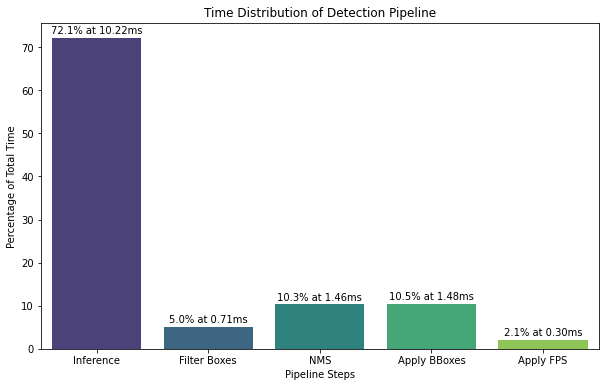

70.56580190820561


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame
data = pd.DataFrame({
    'Pipeline Steps': ['Inference', 'Filter Boxes', 'NMS', 'Apply BBoxes', 'Apply FPS'],
    'Times': [mean_inference, mean_filter_boxes, mean_nms, mean_apply_bboxes, mean_apply_fps]
})

# Calculate the percentage of each part
data['Percentage'] = (data['Times'] / data['Times'].sum()) * 100

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Pipeline Steps', y='Percentage', data=data, palette='viridis')

# Adding percentage labels
for index, row in data.iterrows():
    plt.text(index, row['Percentage'] + 1, f"{row['Percentage']:.1f}% at {row['Times']*1000:.2f}ms", color='black', ha="center")

plt.ylabel('Percentage of Total Time')
plt.title('Time Distribution of Detection Pipeline')
plt.savefig("voc_person_only_new_profile.png")
plt.show()

print(1/mean_total)

<Figure size 432x288 with 0 Axes>